In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decimal import Decimal
from papermodels.paper.pdf import load_pdf_annotations
from papermodels.datatypes.geometry_graph import GeometryGraph
from papermodels.datatypes.joist_models import (
    JoistArrayModel, 
    collector_trib_model
)

In [3]:
%matplotlib inline

## 1. Create the graph

In [4]:
graph = GeometryGraph.from_pdf_file("multi-page-plan.pdf", scale=Decimal(1 / 72 * 4), do_not_process=False)
graph.assign_collector_behaviour(collector_trib_model, as_subelements=False)
les = graph.create_loaded_elements()

## New! Page rotation correction

The page in `multi-page-plan.pdf` is rotated 270 degrees. This is performed by some PDF software to make the page "landscape" whereas other softwares set the dimensions of the page differently. If the PDF software performs a page rotation then `papermodels` will "unrotate it" as can be seen in the plot of the annotations below.

## New! Multiple "pages" on a single sheet

The `multi-page-plan.pdf` has one sheet in the PDF document that has two plan drawings on it. The lower level is on the left and the upper level is on the right. This is called "LTR" (left-to-right) convention where the plan views of the document are organized from the lowest elevations to the highest elevations in the structure. The plan views on the page should have the lowest elevations on the left.

To make sure the pages are aligned with each other, the designer must draw a "page" annotation (a rectangle with the word "page" in the text attribute) and an "origin" annotation (another smaller rectangle with the word "origin" in the text attribute). It is expected to have one origin per page. As long as the origin is drawn at the same location on the plan (i.e. the same grid intersection) such that the origin's centroid is at reference point, and that the "page rectangle" grabs all of the annotations belonging to that page, then the annotations will align across all pages.

See the PDF and see how they are interpreted as separate "pages", below.

These "virtual pages" are treated the exact same as if they were actual separate pages in the PDF. That is, the annotations will be numbered according to which "virtual page" they are on, not the PDF page.

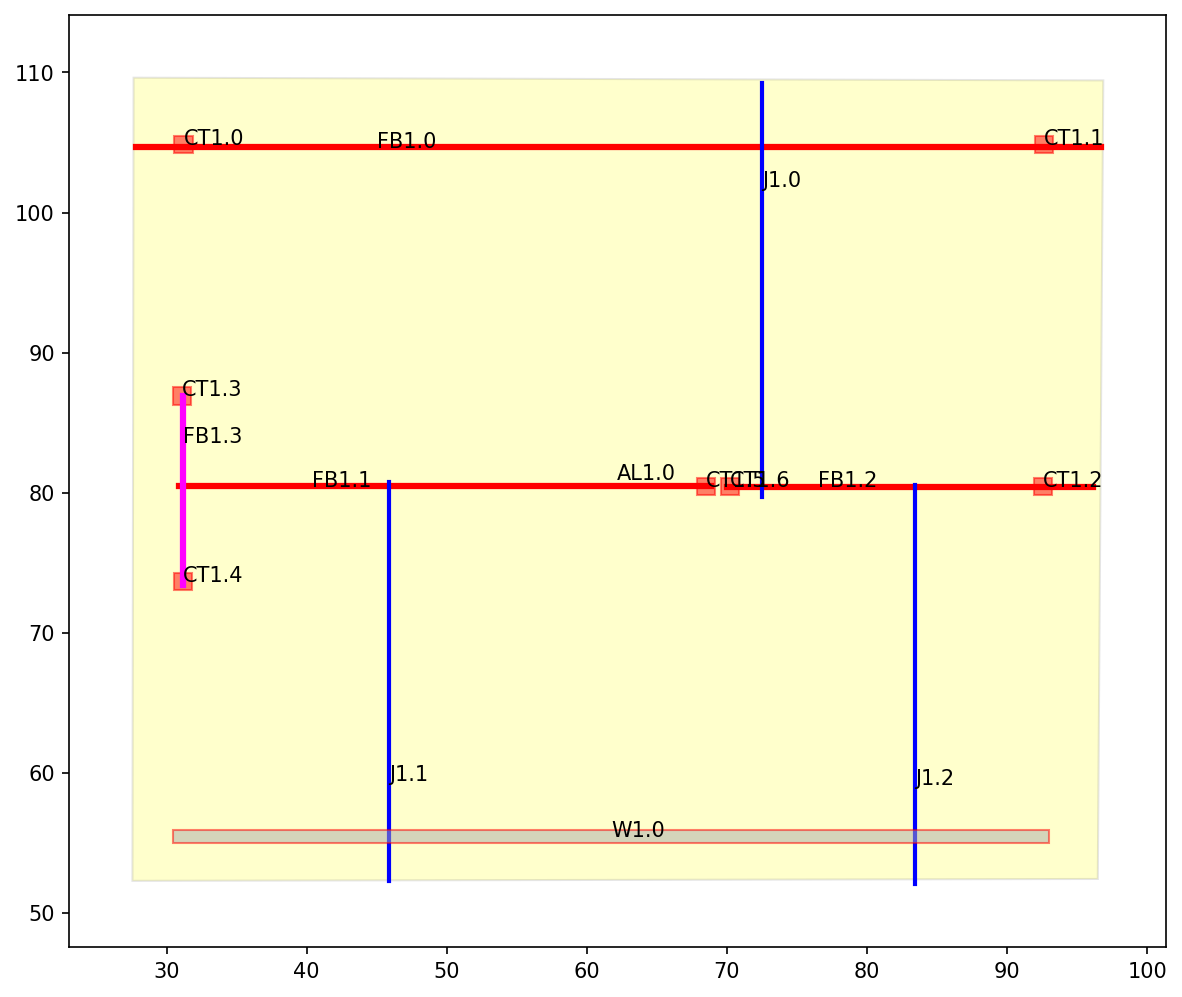

In [5]:
graph.plot_annotations(1)

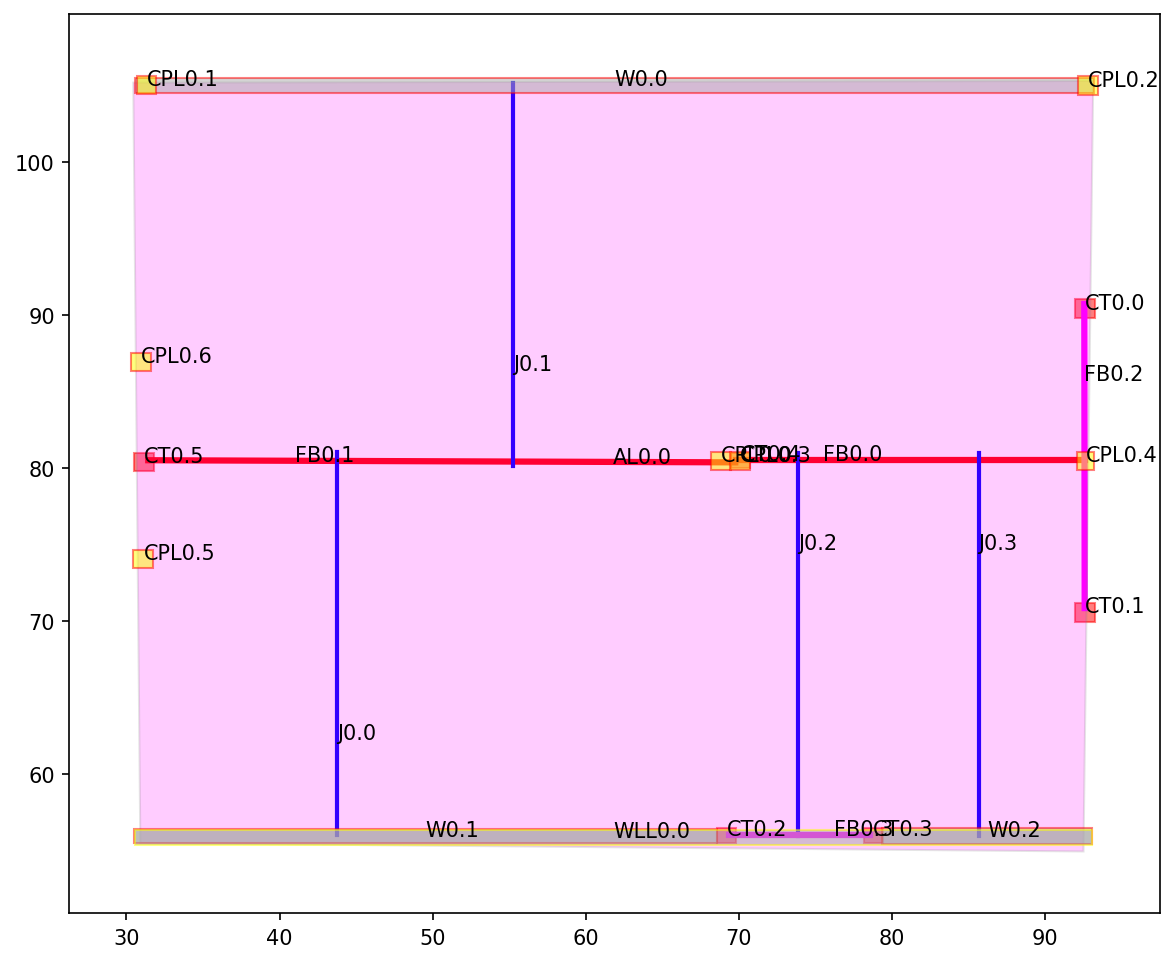

In [6]:
graph.plot_annotations(0)

## New! Disambiguation of load transfer

Previously, if a polygon element (e.g. column, wall) produced a transfer load on a page, that transfer load would set up a "transfer" relationship with all elements that it touches. (See the above plot: the columns transferring out are yellow squares and the walls transferring out are grey rectangles with yellow borders). 

Now, the following rules apply:

1. If a polygon element is transferring out and it has a "point" reaction_type then it will only transfer out to one element on the plane:
    1. If one of the intersecting elements is a frame element, it will transfer out to the frame element that has the largest proportion of overlap with the transferring out element. This allows the designer to control which frame element is the receiving element (see "FB0.2": it is receiving "CPL0.4" instead of "FB0.0". However, if the designer extends the horizontal dimension of CPL0.4 a little and extends the line of FB0.0 so that the lenght of FB0.0 line in the CPL0.4 square is more than the length of FB0.2, then CPL0.4 will transfer to FB0.0 first, before FB0.0 transfers to FB0.2.)
    3. Otherwise it  will transfer out to the polygon element it intersects with that has the largest area of overlap
2. If a polygon element is transferring out and it has a "linear" reaction_type then it will transfer out only to other polygon elements of the same "family" (i.e. the first letter of the tag is the same, e.g. "WLL0.0" -> "W0.1", but not "WLL0.0" -> "CT0.2"). This allows a wall segments to transfer out to other wall segments via a "Wall Line Load" or "Wall Transfer Line" or whatever you call it (as long as it starts with a "W") AND it can also transfer out to beams (since beams are not polygon elements). But walls won't transfer out to columns if they are of different "families".
3. A polygon element can only "correspond" with one polygon element (of the same "family"). This means walls transfer to walls and columns transfer to columns. It also means that the columns can transfer out to something like a "Column Point Load" ("CPL") and that, when the column transfers out the CPL, that is the ONLY polygon it transfers to (it does not also transfer to another column below it).

> **NOTE:** All transferring-out polygon elements (e.g. walls, columns) must have a rank == 0 (so, "Rank: 0" in the legend). This is because it is a load-generating element and should transfer load to "whatever it touches".

### Breaking change!

`LoadedElement.model(precision=3)` is now a method instead of an attribute (property). So you have to call `.model()`, not `.model`.

The new method allows for a user-defined amount of precision in the numbers. Default is 3 decimal places.

In [7]:
# See the "horz_intersects_above" and not that it does _NOT_ include "CPL0.4"
les["FB0.0"].model()

{'element_attributes': {'tag': 'FB0.0',
  'length': 10.967,
  'orientation': 'horizontal',
  'vert_correspondent_below': [],
  'vert_correspondent_above': [],
  'horz_intersects_above': ['J0.2', 'J0.3', 'CPL0.3'],
  'horz_intersects_below': ['CT0.4', 'FB0.2']},
 'element_geometry': {'geometry': 'LINESTRING (33.498 38.658, 44.465 38.658)',
  'supports': [{'location': 0.463, 'fixity': 'pin'},
   {'location': 10.936, 'fixity': 'roller'}]},
 'loads': {'point_loads': [{'location': 0.455,
    'magnitude': 0.0,
    'transfer_source': 'CPL0.3',
    'transfer_reaction_index': 0,
    'direction': 'gravity'}],
  'distributed_loads': [{'transfer_source': 'J0.2',
    'transfer_reaction_index': 1,
    'occupancy': '',
    'load_components': {},
    'applied_area': 0.0,
    'start_loc': 0.0,
    'start_magnitude': 1.0,
    'end_loc': 4.199,
    'end_magnitude': 1.0,
    'direction': 'gravity'},
   {'transfer_source': 'J0.3',
    'transfer_reaction_index': 1,
    'occupancy': '',
    'load_components'

In [8]:
# See how "CPL0.4" is one of the load sources for "FB0.2" instead?
# (See "horz_intersects_above" and the second point load)
les["FB0.2"].model()

{'element_attributes': {'tag': 'FB0.2',
  'length': 9.532,
  'orientation': 'horizontal',
  'vert_correspondent_below': [],
  'vert_correspondent_above': [],
  'horz_intersects_above': ['FB0.0', 'CPL0.4'],
  'horz_intersects_below': ['CT0.0', 'CT0.1']},
 'element_geometry': {'geometry': 'LINESTRING (44.429 43.546, 44.441 34.014)',
  'supports': [{'location': 0.435, 'fixity': 'pin'},
   {'location': 9.37, 'fixity': 'roller'}]},
 'loads': {'point_loads': [{'location': 4.889,
    'magnitude': 0.0,
    'transfer_source': 'FB0.0',
    'transfer_reaction_index': 1,
    'direction': 'gravity'},
   {'location': 4.916,
    'magnitude': 0.0,
    'transfer_source': 'CPL0.4',
    'transfer_reaction_index': 0,
    'direction': 'gravity'}],
  'distributed_loads': []}}

## 2. Output the model files

Currently outputs in either JSON or TOML. Both are equivalent to a dictionary and can be parsed by modules in the standard library, i.e. `toml`, `json`.

In [9]:
import pathlib
output_dir = pathlib.Path("model_files")

file_format = "toml" # also try "json"

for loaded_element in les.values():
    if file_format == "toml":
        output_toml = output_dir / "toml"
        output_toml.mkdir(parents=True, exist_ok=True)
        with open(output_dir / "toml" / f"{loaded_element.tag}.toml", "wb") as file:
            loaded_element.dump_toml(file, precision=4) # You can set the precision here, too
    elif file_format == "json":
        output_json = output_dir / "json"
        output_json.mkdir(parents=True, exist_ok=True)
        with open(output_dir / "json" / f"{loaded_element.tag}.json", "w") as file:
            loadeded_element.dump_json(file, precision=4) # You can set the precision here, too
        